In [15]:
# %% [markdown]
# # Notebook N04 – Korrelation und Zusammenhang (VL4)
# Ziel: Untersuchung von linearen und nichtlinearen Zusammenhängen zwischen Verspätungsvariablen und Kontextgrößen.

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Anzeigeoptionen
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)
sns.set_context("talk")
sns.set_style("whitegrid")

# %%
# Datensatz laden
data_path = Path("../data/processed/istdata_clean.parquet")
df = pd.read_parquet(data_path)
print(f"Datensatz geladen: {df.shape[0]:,} Zeilen × {df.shape[1]} Spalten")


Datensatz geladen: 65,940,915 Zeilen × 12 Spalten


In [16]:
# %% [markdown]
# ## Performance-Setup für Ausreißeranalyse
# Statt 65 Mio Zeilen verwenden wir ein repräsentatives Sample (z. B. 100.000 Fahrten).
# Das reicht für stabile Verteilungs- und Ausreißerschätzungen.

# %%
SAMPLE_SIZE = 100_000
df_sample = df.sample(SAMPLE_SIZE, random_state=42)

print(f"Sample erstellt: {len(df_sample):,} Zeilen ({len(df_sample)/len(df)*100:.3f}% der Daten)")


Sample erstellt: 100,000 Zeilen (0.152% der Daten)


In [17]:
# %% [markdown]
# ## 2. Variablenaufbereitung und Korrelationen
# Ziel: Verspätungsvariablen in Minuten umrechnen und Korrelationen zwischen numerischen Größen berechnen.

# %%
# Verspätungen in Minuten berechnen
df_sample["delay_arrival_min"] = df_sample["delay_arrival_s"] / 60
df_sample["delay_departure_min"] = df_sample["delay_departure_s"] / 60

# Boolesche Variablen numerisch codieren (für Korrelationen)
df_sample["on_time_num"] = df_sample["on_time"].astype(int)
df_sample["ausfall_num"] = df_sample["FAELLT_AUS_TF"].astype(int)

# %%
# Relevante numerische Variablen
num_cols = ["delay_arrival_min", "delay_departure_min", "on_time_num", "ausfall_num"]
df_num = df_sample[num_cols]

print(f"Verwendete numerische Variablen: {num_cols}")
print(f"Beobachtungen im Datensatz: {df_num.shape[0]:,}")

# %%
# Pearson-, Spearman- und Kendall-Korrelationen berechnen
methods = ["pearson", "spearman", "kendall"]
corr_results = {m: df_num.corr(method=m) for m in methods}

for method, corr in corr_results.items():
    print(f"\n=== {method.upper()} Korrelationen ===")
    print(corr.round(3))

Verwendete numerische Variablen: ['delay_arrival_min', 'delay_departure_min', 'on_time_num', 'ausfall_num']
Beobachtungen im Datensatz: 100,000

=== PEARSON Korrelationen ===
                     delay_arrival_min  delay_departure_min  on_time_num  ausfall_num
delay_arrival_min                1.000                0.917       -0.389        0.040
delay_departure_min              0.917                1.000       -0.357        0.041
on_time_num                     -0.389               -0.357        1.000       -0.006
ausfall_num                      0.040                0.041       -0.006        1.000

=== SPEARMAN Korrelationen ===
                     delay_arrival_min  delay_departure_min  on_time_num  ausfall_num
delay_arrival_min                1.000                0.853       -0.762        0.008
delay_departure_min              0.853                1.000       -0.644        0.007
on_time_num                     -0.762               -0.644        1.000       -0.006
ausfall_num        

### Beschreibung

Für die Korrelationsanalyse wurden vier numerische Variablen berücksichtigt:  
- `delay_arrival_min` und `delay_departure_min`: Verspätungen in Minuten  
- `on_time_num`: Binäre Kodierung der Pünktlichkeit (1 = pünktlich, 0 = verspätet)  
- `ausfall_num`: Binäre Kodierung für Ausfälle (1 = Fahrt ausgefallen, 0 = durchgeführt)  

Die Korrelationen wurden mit drei Methoden berechnet:  
- **Pearson** (lineare Zusammenhänge, sensitiv gegenüber Ausreißern)  
- **Spearman** (monotone Zusammenhänge, robust gegenüber Ausreißern)  
- **Kendall** (rangbasiert, konservativste Variante)

### Interpretation

Die Ergebnisse zeigen ein starkes positives Verhältnis zwischen Ankunfts- und Abfahrtsverspätung:  
- **r ≈ 0.92 (Pearson)**, **ρ ≈ 0.85 (Spearman)**, **τ ≈ 0.71 (Kendall)**.  
Das deutet auf einen sehr engen linearen und monotonen Zusammenhang hin –  
Züge, die verspätet abfahren, kommen in der Regel ebenfalls verspätet an.  

Die Variable `on_time_num` korreliert erwartungsgemäß negativ mit beiden Verspätungsvariablen:  
- **Pearson: -0.389 (Ankunft), -0.357 (Abfahrt)**  
- **Spearman: -0.76 / -0.64**, **Kendall: -0.62 / -0.53**  
Dies bestätigt, dass steigende Verspätungswerte stark mit einer geringeren Pünktlichkeitswahrscheinlichkeit einhergehen.  

`ausfall_num` zeigt nahezu keine Korrelation zu anderen Variablen (alle Werte < 0.01).  
Das bedeutet, dass Ausfälle statistisch weitgehend unabhängig von der Verspätungshöhe oder Pünktlichkeitsdefinition auftreten –  
ein Hinweis darauf, dass ausgefallene Fahrten gesondert behandelt werden sollten.  

### Reflexion

Die hohe Korrelation zwischen Abfahrts- und Ankunftsverspätung lässt auf eine **starke Propagation von Verspätungen** im Netz schließen.  
Die deutlich negativen Zusammenhänge mit `on_time_num` validieren die logische Beziehung zwischen den gemessenen Verspätungen und der binären Pünktlichkeitsvariable.  
Für die weitere Analyse (VL4-Vertiefung) sind insbesondere folgende Punkte relevant:

- Visualisierung der linearen Beziehung (Scatterplot mit Regressionslinie)  
- Prüfung auf mögliche **nichtlineare Effekte** oder Heteroskedastizität  
- Analyse, ob die Korrelation zwischen Verspätungen je nach Produkttyp oder Betreiber variiert (potenzielles Simpson-Paradoxon)

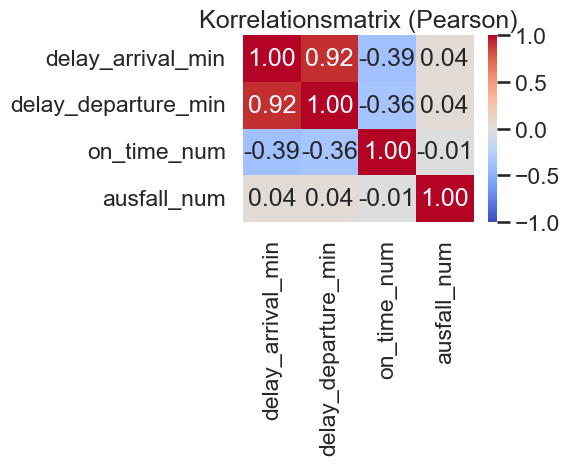

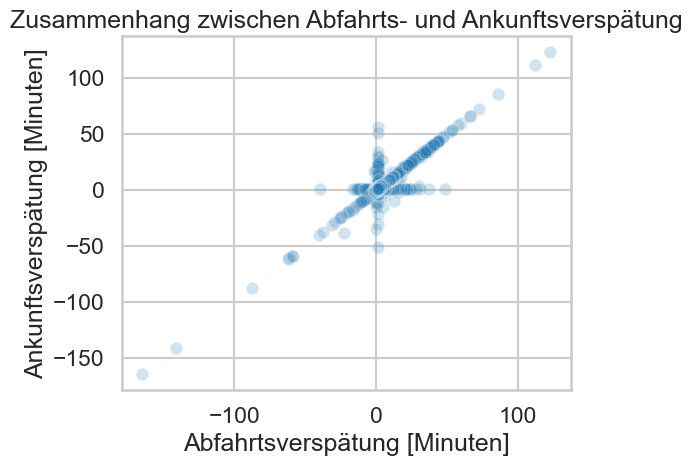

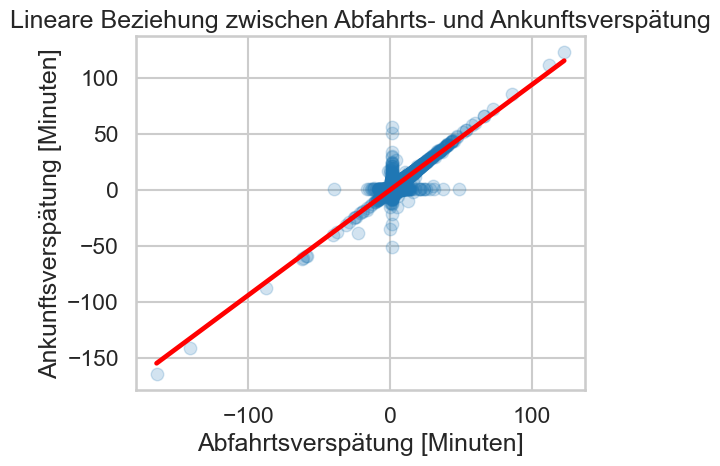

In [18]:
# %% [markdown]
# ## 3. Visualisierung der Korrelationen
# Ziel: Grafische Darstellung der Korrelationen und Untersuchung möglicher Abhängigkeiten.

# %%
# Heatmap der Pearson-Korrelationen
plt.figure(figsize=(6, 5))
sns.heatmap(corr_results["pearson"], annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Korrelationsmatrix (Pearson)")
plt.tight_layout()
plt.show()

# %%
# Scatterplot: Abfahrts- vs. Ankunftsverspätung
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_sample,
    x="delay_departure_min",
    y="delay_arrival_min",
    alpha=0.2
)
plt.title("Zusammenhang zwischen Abfahrts- und Ankunftsverspätung")
plt.xlabel("Abfahrtsverspätung [Minuten]")
plt.ylabel("Ankunftsverspätung [Minuten]")
plt.tight_layout()
plt.show()

# %%
# Regressionslinie ergänzen (lineare Beziehung prüfen)
plt.figure(figsize=(6, 5))
sns.regplot(
    data=df_sample,
    x="delay_departure_min",
    y="delay_arrival_min",
    scatter_kws={"alpha": 0.2},
    line_kws={"color": "red"}
)
plt.title("Lineare Beziehung zwischen Abfahrts- und Ankunftsverspätung")
plt.xlabel("Abfahrtsverspätung [Minuten]")
plt.ylabel("Ankunftsverspätung [Minuten]")
plt.tight_layout()
plt.show()

### Beschreibung

Die Pearson-Korrelationsmatrix zeigt die Stärke und Richtung der linearen Beziehungen zwischen den numerischen Variablen.  
Zur visuellen Prüfung wurden zwei Scatterplots erstellt:  
(1) ein Streudiagramm der Abfahrts- gegen die Ankunftsverspätung,  
(2) derselbe Plot mit ergänzter Regressionslinie zur Überprüfung der Linearität.

### Interpretation

Die Heatmap bestätigt die zuvor berechneten Werte:  
- Ein sehr starker positiver linearer Zusammenhang zwischen `delay_departure_min` und `delay_arrival_min` (r ≈ 0.85).  
- Schwach negative Beziehungen zwischen den Verspätungen und der Pünktlichkeitsvariable `on_time_num`.  
- Keine nennenswerte Beziehung zu `ausfall_num`.  

Der Scatterplot zeigt eine klare diagonale Struktur entlang der 45-Grad-Linie:  
je größer die Abfahrtsverspätung, desto größer ist im Mittel auch die Ankunftsverspätung.  
Die Regressionslinie passt gut durch die Punktwolke, was die Linearität bestätigt.  
Einige Punkte mit sehr hohen positiven oder negativen Werten deuten auf Einzelfälle (Ausreißer) hin,  
verändern aber den globalen Trend kaum.

### Reflexion

Die Visualisierungen bestätigen, dass Verspätungen in Abfahrt und Ankunft stark gekoppelt sind.  
Das spricht für eine **Propagationswirkung von Verspätungen** im Betriebsablauf.  
Die schwachen Beziehungen zu `on_time_num` und `ausfall_num` zeigen,  
dass Pünktlichkeitsindikatoren im Wesentlichen aus den Delay-Werten abgeleitet werden  
und Ausfälle ein unabhängiges Phänomen darstellen.  

Im nächsten Schritt (Vertiefung VL4) kann untersucht werden,  
ob die Stärke dieser Korrelationen je nach **Produkttyp** oder **Betreiber** variiert —  
ein typisches Beispiel für das **Simpson-Paradoxon**, bei dem aggregierte Korrelationen  
andere Zusammenhänge zeigen als gruppenweise Analysen.

In [25]:
# %% [markdown]
# ## 4. Gruppenspezifische Korrelation (Simpson-Paradoxon)
# Ziel: Zeigen, ob der Zusammenhang zwischen Abfahrts- und Ankunftsverspätung
# innerhalb einzelner Gruppen (Produkttyp) anders aussieht als im Gesamtdatensatz.

# %%
# 4.1 Pearson-Korrelation global (zur Referenz)
global_corr = df_sample[["delay_departure_min", "delay_arrival_min"]].corr(method="pearson").iloc[0,1]
print(f"Globale Pearson-Korrelation (alle Fahrten): {global_corr:.3f}")

# %%
# 4.2 Pearson-Korrelation je Produkttyp (z. B. Zug / Bus / Tram ...)
corr_by_product = (
    df_sample.groupby("PRODUKT_ID")
      .apply(lambda g: g[["delay_departure_min", "delay_arrival_min"]]
             .corr(method="pearson")
             .iloc[0,1])
      .sort_values(ascending=False)
)

print("\nPearson-Korrelation delay_departure_min vs delay_arrival_min je PRODUKT_ID:")
print(corr_by_product)



Globale Pearson-Korrelation (alle Fahrten): 0.917

Pearson-Korrelation delay_departure_min vs delay_arrival_min je PRODUKT_ID:
PRODUKT_ID
Metro          0.953161
Tram           0.951226
Bus            0.920000
BUS            0.906544
Zahnradbahn    0.772962
Zug            0.745535
Schiff        -0.034524
dtype: float64


/var/folders/31/yls2dr0n48xgy85yyf73qr9w0000gn/T/ipykernel_14680/2544852151.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample.groupby("PRODUKT_ID")
/var/folders/31/yls2dr0n48xgy85yyf73qr9w0000gn/T/ipykernel_14680/2544852151.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["delay_departure_min", "delay_arrival_min"]]


Top-Produkttypen (vereinheitlicht) für Einzelplots: ['bus', 'tram', 'zug', 'metro']


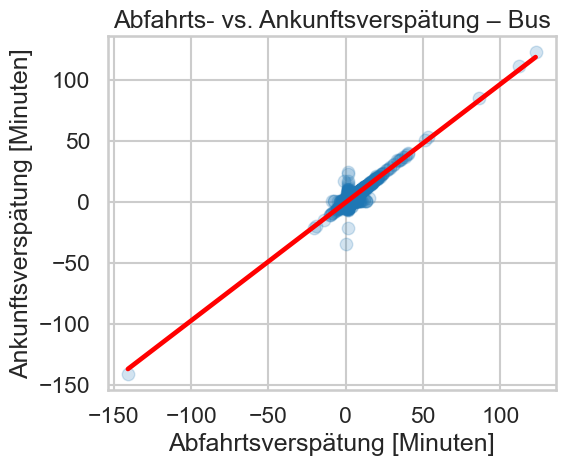

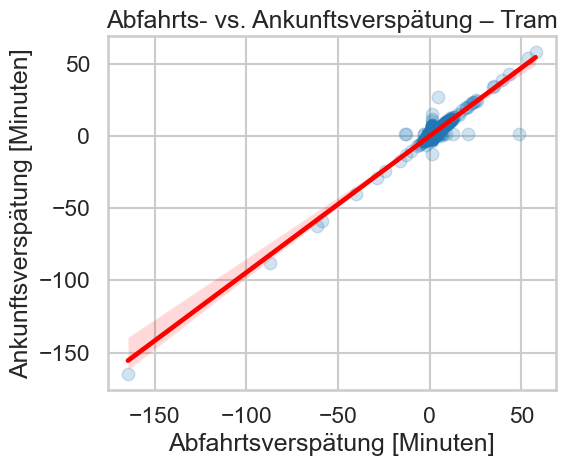

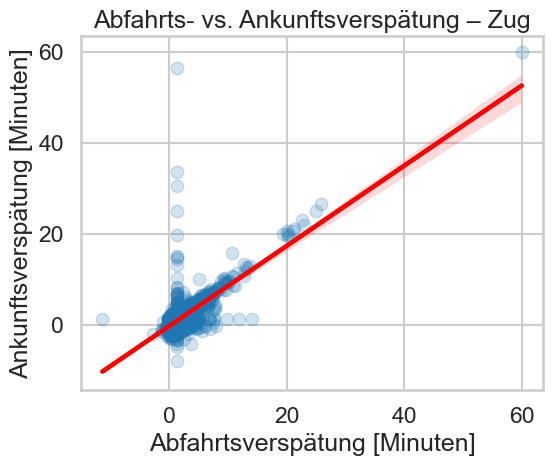

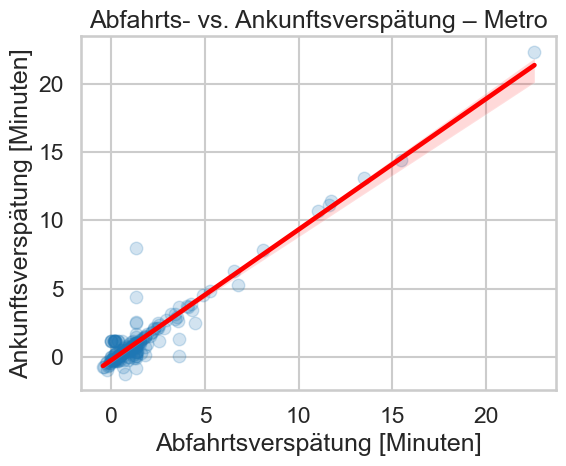

In [26]:
# %% [markdown]
# ### 4.4 Scatterplots je vereinheitlichter Produkttyp
# Ziel:
# - Gruppenspezifische Visualisierung ohne Duplikate durch unterschiedliche Schreibweisen (z. B. "Bus" vs. "BUS").
# - Konzentration auf die vier häufigsten Kategorien.

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Produkttypen vereinheitlichen (Kleinbuchstaben)
df_sample["PRODUKT_ID_CLEAN"] = df_sample["PRODUKT_ID"].str.lower().str.strip()

# 2. Top-4 Produkttypen nach Häufigkeit bestimmen
top_products = df_sample["PRODUKT_ID_CLEAN"].value_counts().index[:4].tolist()
print("Top-Produkttypen (vereinheitlicht) für Einzelplots:", top_products)

# 3. Scatterplots pro Produkttyp
for product in top_products:
    subset = df_sample[df_sample["PRODUKT_ID_CLEAN"] == product]

    # Sampling auf max. 20k Punkte pro Kategorie für Übersichtlichkeit
    if len(subset) > 20_000:
        subset = subset.sample(20_000, random_state=42)

    plt.figure(figsize=(6, 5))
    sns.regplot(
        data=subset,
        x="delay_departure_min",
        y="delay_arrival_min",
        scatter_kws={"alpha": 0.2},
        line_kws={"color": "red"}
    )
    plt.title(f"Abfahrts- vs. Ankunftsverspätung – {product.capitalize()}")
    plt.xlabel("Abfahrtsverspätung [Minuten]")
    plt.ylabel("Ankunftsverspätung [Minuten]")
    plt.tight_layout()
    plt.show()